## embedding timeseries in a lazy dask framework?



In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
import numpy as np 
import yt 
import dask 
import glob 
import yt 
import os 
from dask.distributed import Client

%matplotlib inline

yt.set_log_level(50)  # disable yt logging

In [2]:
yt_data_dir = yt.config.ytcfg.get('yt', 'test_data_dir')
ds_files = glob.glob(os.path.join(yt_data_dir, "enzo_tiny_cosmology/DD????/DD????"))
ds_files.sort()

In [9]:
glob.glob(os.path.join("enzo_tiny_cosmology/DD????/DD????"))

[]

In [18]:
glob.glob(os.path.join(yt_data_dir, "enzo_tiny_cosmology/*"))

['/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/32Mpc_32.enzo',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0041',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0014',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/32Mpc_32.inits',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0046',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0009',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0018',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0019',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0040',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0021',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0012',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cosmology/DD0036',
 '/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_tiny_cos

In [3]:
c = Client(threads_per_worker=10, n_workers=5)

In [4]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 50,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42101,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:38675,Total threads: 10
Dashboard: http://127.0.0.1:37595/status,Memory: 6.24 GiB
Nanny: tcp://127.0.0.1:39221,


In [5]:
%%time

basenames = [] 

def center_slice_frb(ds_id, field):  
    yt.set_log_level(50)  # disable yt logging here... this actually makes it thread safe-ish?
    ds = yt.load(ds_files[ds_id])
    slc = ds.slice(0, ds.domain_center[0])    
    return slc.to_frb(1., (1200, 1200))[field]

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(dask.delayed(center_slice_frb)(ds_id, field))

CPU times: user 9.57 ms, sys: 3.92 ms, total: 13.5 ms
Wall time: 12.6 ms


In [6]:
%%time
slices = dask.compute(*basenames)#, scheduler='processes' )

Parsing Hierarchy :   0%|          | 0/189 [00:00<?, ?it/s]


Parsing Hierarchy :   0%|          | 0/41 [00:00<?, ?it/s]



Parsing Hierarchy :   0%|          | 0/143 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|          | 0/147 [00:00<?, ?it/s]


Parsing Hierarchy :   0%|          | 0/137 [00:00<?, ?it/s]



Parsing Hierarchy :   0%|          | 0/104 [00:00<?, ?it/s]




Parsing Hierarchy :   0%|          | 0/182 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|          | 0/146 [00:00<?, ?it/s][A


Parsing Hierarchy :   0%|          | 0/214 [00:00<?, ?it/s]



Parsing Hierarchy : 100%|██████████| 54/54 [00:00<00:00, 6615.04it/s]s]


Parsing Hierarchy :   0%|          | 0/2 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████| 160/160 [00:00<00:00, 13109.76it/s]

Parsing Hierarchy :   0%|          | 0/66 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|          | 0/211 [00:00<?, ?it/s]



Parsing Hierarchy :   0%|          | 0/86 [00:00<?, ?it/s]


Parsing Hierarchy :  37%|███▋      | 15/41 [00:

CPU times: user 4.15 s, sys: 829 ms, total: 4.98 s
Wall time: 27.3 s


In [9]:
len(slices)

47

In [10]:
slices[0]

array([[0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       [0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       [0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       ...,
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937],
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937],
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937]])

In [11]:

def g(slice_id):
    plt.figure(figsize=(12,12))
    plt.imshow(np.log10(slices[slice_id]))
    plt.show()

interactive_plot = interactive(g, slice_id=widgets.IntSlider(0, 0, len(slices)-1, 1))
interactive_plot

interactive(children=(IntSlider(value=0, description='slice_id', max=46), Output()), _dom_classes=('widget-int…

In [12]:
# c.close()

## baseline comparison

In [7]:
%%time

basenames = [] 

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(center_slice_frb(ds_id, field))

Parsing Hierarchy : 100%|█████████████████████████████████████████| 211/211 [00:00<00:00, 19189.86it/s]


CPU times: user 36.8 s, sys: 913 ms, total: 37.7 s
Wall time: 38.4 s


## Thread safety

In [4]:
%%time
slices = dask.compute(*basenames, scheduler="threads")

Parsing Hierarchy :   0%|                               | 0/123 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|                               | 0/105 [00:00<?, ?it/s]


Parsing Hierarchy : 100%|███████████████████| 123/123 [00:00<00:00, 1969.31it/s]





Parsing Hierarchy : 100%|██████████████████████| 55/55 [00:00<00:00, 806.85it/s]




Parsing Hierarchy : 100%|██████████████████| 146/146 [00:00<00:00, 23627.15it/s]


CPU times: user 49.6 s, sys: 4.48 s, total: 54.1 s
Wall time: 47.8 s


## how bout the ts object?

In [25]:
ts = yt.load("enzo_tiny_cosmology/DD????/DD????")

In [26]:
%%time

basenames = [] 

def center_slice_frb_ds(ds, field):          
    slc = ds.slice(0, ds.domain_center[0])    
    return slc.to_frb(1., (1200, 1200))[field]

field = ('enzo', 'Density')
for ds in ts:     
    basenames.append(dask.delayed(center_slice_frb)(ds, field))

CPU times: user 3.07 s, sys: 89.9 ms, total: 3.16 s
Wall time: 3.16 s


In [27]:
slices = dask.compute(*basenames)  

2023-08-09 15:49:50,700 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/home/chavlin/miniconda3/envs/yt_py39/lib/python3.9/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
  File "/home/chavlin/miniconda3/envs/yt_py39/lib/python3.9/site-packages/distributed/protocol/core.py", line 138, in _decode_default
    return merge_and_deserialize(
  File "/home/chavlin/miniconda3/envs/yt_py39/lib/python3.9/site-packages/distributed/protocol/serialize.py", line 497, in merge_and_deserialize
    return deserialize(header, merged_frames, deserializers=deserializers)
  File "/home/chavlin/miniconda3/envs/yt_py39/lib/python3.9/site-packages/distributed/protocol/serialize.py", line 410, in deserialize
    deserialize(
  File "/home/chavlin/miniconda3/envs/yt_py39/lib/python3.9/site-packages/distributed/protocol/serialize.py", line 42

KilledWorker: ('center_slice_frb-78e38196-a0f0-4977-b503-a010a6f5ea20', <WorkerState 'tcp://127.0.0.1:40425', name: 3, status: closed, memory: 0, processing: 47>)

# as a dask array

In [12]:
%%time

basenames = [] 

nx = 1200 
ny = 1200
def center_slice_frb(ds_id, field):  
    # yt.set_log_level(50)  # disable yt logging here...
    ds = yt.load(ds_files[ds_id])
    slc = ds.slice(0, ds.domain_center[0])    
    return np.log10(slc.to_frb(1., (nx, ny))[field])

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(dask.delayed(center_slice_frb)(ds_id, field))

CPU times: user 4.03 ms, sys: 4.44 ms, total: 8.47 ms
Wall time: 7.77 ms


In [5]:
from dask import array as da

In [14]:
delayed_arrays = [da.from_delayed(b, (nx, ny),dtype=float) for b in basenames]

In [15]:
delayed_im_array = da.stack(delayed_arrays)

In [16]:
delayed_im_array

dask.array<stack, shape=(47, 1200, 1200), dtype=float64, chunksize=(1, 1200, 1200), chunktype=numpy.ndarray>

Parsing Hierarchy : 100%|██████████| 2/2 [00:00<00:00, 20560.31it/s]


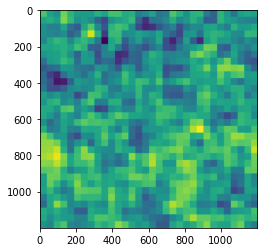

In [17]:
plt.imshow(delayed_im_array[0,:,:])

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 24493.47it/s]


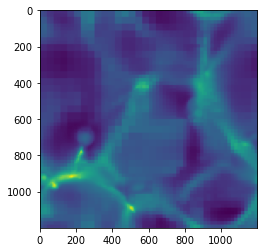

In [18]:
plt.imshow(delayed_im_array[-1,:,:])

In [19]:
delayed_im_array

dask.array<stack, shape=(47, 1200, 1200), dtype=float64, chunksize=(1, 1200, 1200), chunktype=numpy.ndarray>

In [9]:
import napari

In [10]:
v = napari.Viewer()

In [23]:
v.add_image(delayed_im_array, contrast_limits=(-1.7, 2))

Parsing Hierarchy : 100%|██████████| 120/120 [00:00<00:00, 25149.48it/s]


<Image layer 'delayed_im_array' at 0x7f5465b413d0>

Parsing Hierarchy : 100%|██████████| 189/189 [00:00<00:00, 22604.03it/s]


In [24]:
v.add_image(delayed_im_array.compute(), contrast_limits=(-1.7, 2))

Parsing Hierarchy : 100%|██████████| 120/120 [00:00<00:00, 17753.04it/s]

Parsing Hierarchy :   0%|          | 0/146 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████| 162/162 [00:00<00:00, 3656.84it/s]



Parsing Hierarchy :   0%|          | 0/146 [00:00<?, ?it/s]589.24it/s]

Parsing Hierarchy :   0%|          | 0/12 [00:00<?, ?it/s]


Parsing Hierarchy :   0%|          | 0/66 [00:00<?, ?it/s]]



Parsing Hierarchy :   0%|          | 0/167 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|          | 0/187 [00:00<?, ?it/s]

Parsing Hierarchy :   0%|          | 0/214 [00:00<?, ?it/s]


Parsing Hierarchy : 100%|██████████| 137/137 [00:00<00:00, 775.77it/s]


Parsing Hierarchy : 100%|██████████| 159/159 [00:00<00:00, 4696.51it/s]

Parsing Hierarchy : 100%|██████████| 188/188 [00:00<00:00, 2083.37it/s]


<Image layer 'Image' at 0x7f5464184e80>

Parsing Hierarchy : 100%|██████████| 147/147 [00:00<00:00, 16695.44it/s]


## Region 

In [6]:
%%time

basenames = [] 

nx = 200
ny = 200 
nz = 200 

def center_reg_frb(ds_id, field):  
    yt.set_log_level(50)  # disable yt logging here... this actually makes it thread safe-ish?
    ds = yt.load(ds_files[ds_id])
    
    reg_hwid = ds.domain_width / 2.
    le = ds.domain_center - reg_hwid
    re = ds.domain_center + reg_hwid
    reg = ds.region(ds.domain_center, le, re)
    
    grid = ds.r[le[0]:re[0]:complex(0,nx), le[1]:re[1]:complex(0,ny), le[2]:re[2]:complex(0,nz)]    
    return grid[field]

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(dask.delayed(center_reg_frb)(ds_id, field))

CPU times: user 6.82 ms, sys: 0 ns, total: 6.82 ms
Wall time: 6.17 ms


In [7]:
delayed_arrays = [da.from_delayed(b, (nx, ny, nz),dtype=float) for b in basenames]

In [8]:
im_array = da.stack(delayed_arrays)
im_array

,Array,Chunk
Bytes,2.80 GiB,61.04 MiB
Shape,"(47, 200, 200, 200)","(1, 200, 200, 200)"
Count,141 Tasks,47 Chunks
Type,float64,numpy.ndarray


In [11]:
im_array.shape

(47, 200, 200, 200)

In [13]:
v.add_image(im_array)

Parsing Hierarchy : 100%|██████████| 120/120 [00:00<00:00, 27727.88it/s]


<Image layer 'im_array' at 0x7f4bd02b9bb0>

Parsing Hierarchy : 100%|██████████| 167/167 [00:00<00:00, 1458.01it/s]


In [15]:

def get_delayed_array(field):
    for ds_id in range(len(ds_files)):     
        basenames.append(dask.delayed(center_reg_frb)(ds_id, field))

    delayed_arrays = [da.from_delayed(b, (nx, ny, nz),dtype=float) for b in basenames]
    im_array = da.stack(delayed_arrays)
    return im_array 


dens = get_delayed_array(('enzo', 'Density'))
temp = get_delayed_array(('enzo', 'Temperature'))

In [18]:
v.add_image(dens)

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 1597.21it/s]


<Image layer 'dens' at 0x7f4bc7221fa0>

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 26450.23it/s]


In [19]:
v.add_image(temp)

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 1488.68it/s]


<Image layer 'temp' at 0x7f4c0efcc8e0>

Parsing Hierarchy : 100%|██████████| 160/160 [00:00<00:00, 25401.74it/s]


In [8]:
import multiprocessing

In [22]:
from dask import array as da 

In [26]:
arr_list = [da.random.random((1000,1000), chunks=100) for _ in range(10)]

In [27]:
arr_list

[dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.arra

In [28]:
import numpy as np 


In [32]:
arrout = np.stack(arr_list)

In [33]:
arrout

dask.array<stack, shape=(10, 1000, 1000), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>

In [40]:
import numpy as np 

np.log10(10*100*100*100)

7.0

In [43]:
ds = yt.load_sample("IsolatedGalaxy")

In [44]:
ds.coordinates.axis_id[self.normal]

{'x': 0, 0: 0, 'y': 1, 1: 1, 'z': 2, 2: 2}

{0: ('y', 'z'),
 'x': ('y', 'z'),
 'X': ('y', 'z'),
 1: ('z', 'x'),
 'y': ('z', 'x'),
 'Y': ('z', 'x'),
 2: ('x', 'y'),
 'z': ('x', 'y'),
 'Z': ('x', 'y')}